In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

from optic.core import parameters
from optic.models import phaseNoise

## Giles class

In [2]:
class giles:
    def __init__(self, parameters):
        self.file = getattr(parameters, "file", "")
        if not (os.path.exists(self.file)):
            raise TypeError(f"{self.file} file doesn't exist.")
        self.type = getattr(parameters, "type", "coeff")
        # set frequency
        self.set_wavelength_from_file()
        if (self.type=='coeff'):
            self.set_coefficients_from_file()
        elif (self.type=='cross'):
            self.set_cross_section_from_file()
        else:
            raise TypeError("gile.type invalid argument - ['coeff', 'cross'].")

    def set_wavelength_from_file(self):
        # Waiting wavelength in nm
        self.wavelength = 1e-9*np.loadtxt(self.file)[:,0]
    
    def set_coefficients_from_file(self):
        file_data = np.loadtxt(self.file)
        self.absorption_coefficient  = 0.1 * np.log(10) * file_data[:,1]
        self.gain_coefficient = 0.1 * np.log(10) * file_data[:,2]

    def set_coefficients_from_cross_section(self, rho, gamma):
        self.absorption_coefficient = self.absorption_cross * rho * gamma
        self.gain_coefficient = self.emission_cross * rho * gamma

    def set_cross_section_from_file(self):
        file_data = np.loadtxt(self.file)
        self.absorption_cross = file_data[:, 1]
        self.emission_cross = file_data[:, 2]

    def set_cross_section_from_coefficients(self, rho, gamma):
         self.absorption_cross = self.absorption_coefficient / rho / gamma
         self.emission_cross = self.gain_coefficient / rho / gamma

    def plot(self,type):
        if (type=='coeff'):
            plt.plot(1e9*self.wavelength, self.absorption_coefficient, label='Abs. coeff.')
            plt.plot(1e9*self.wavelength, self.gain_coefficient, label='Gain coeff.')
            plt.ylabel('EDF coeff. [dB/m]')
        elif (type=='cross'):
            plt.plot(1e9*self.wavelength, 1e25*self.absorption_cross, label='Abs. cross-section')
            plt.plot(1e9*self.wavelength, 1e25*self.emission_cross, label='Em. cross-section')
            plt.ylabel(r'Cross-section [10$^{-25}$ m$^2$]')
        else:
            raise TypeError("type invalid argument - ['coeff', 'cross'].")

        plt.xlabel('Wavelenght [nm]')
        plt.grid(True)
        plt.legend()    

**Example**

In [3]:
import os.path as path

param_giles = parameters()
param_giles.file = 'giles_MP980.dat'
param_giles.file = path.join(path.abspath(path.join("../")), 'optic', 'ampParams', param_giles.file)

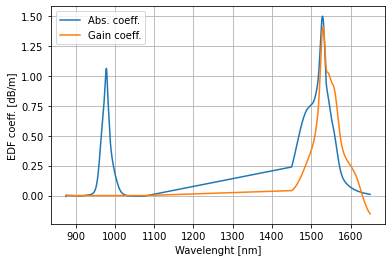

In [4]:
edf_giles = giles(param_giles)
edf_giles.plot('coeff')

## EDF Class

In [5]:
from scipy.special import jv, kv
class edf(giles):
    def __init__(self,parameter):
        # init giles parameters
        super().__init__(parameter.giles)
        # init geometric and material parameters
        self.a = getattr(parameter, "a", 1.56e-6)
        self.b = getattr(parameter, "b", 1.56e-6)
        self.length = getattr(parameter, "length", 8)
        self.rho = getattr(parameter, "rho", 0.955e25)
        self.na = getattr(parameter, "na", 0.22)
        # init algorithm parameters
        self.geometric = getattr(parameter, "geometric", "Bessel")
        self.algorithm = getattr(parameter, "algorithm", "Giles_spectrum")
        self.longitudinal_steps = getattr(parameter, "longitudinal_steps", 100)
        # init physical paramters
        self.tal = getattr(parameter, "tal", 10e-3)
        # init signal and pump loss paramters
        self.loss_signal = getattr(parameter, "loss_signal", 2.08 * 0.0001 * np.log10(10))
        self.loss_pump = getattr(parameter, "loss_pump", 2.08 * 0.0001 * np.log10(10))

        if self.algorithm not in (
        "Giles_spatial",
        "Giles_spectrum",
        "Saleh",
        "Jopson",
        "Inhomogeneous",
        ):
            raise TypeError(
                "edfaSM.algo invalid argument - [Giles_spatial, Giles_spectrum, Saleh, Jopson, Inhomogeneous]."
                )

        self.set_radius()
        self.set_modal_parameters()
        if (self.geometric != 'LP01'):
            self.set_mode_radius()
        self.set_gamma()
        try:
            self.set_cross_section_from_coefficients(self.rho, self.gamma)
        except Exception:
            self.set_coefficients_from_cross_section(self.rho, self.gamma)
        if (self.algorithm == 'Giles_spatial'):
            self.set_ik()


    def set_radius(self):
        # Logitudinal step
        self.dr = self.a / self.longitudinal_steps
        self.r  = np.arange(0, self.a, self.dr)

    def set_modal_parameters(self):
        self.V = (2 * np.pi / self.wavelength) * self.a * self.na
        # u and v calculation for LP01 and Bessel profiles
        self.u = ((1 + np.sqrt(2)) * self.V) / (1 + (4 + self.V ** 4) ** 0.25)
        self.v = np.sqrt(self.V ** 2 - self.u ** 2)

    def set_mode_radius(self):
        if self.geometric == "Bessel":
            self.w_gauss = self.a * self.V / self.u * kv(1, self.v) / kv(0, self.v) * jv(0, self.u)
        elif self.geometric == "Marcuse":
            self.w_gauss = self.a * (0.650 + 1.619 / self.V ** 1.5 + 2.879 / self.V ** 6)
        elif self.geometric == "Whitley":
            self.w_gauss = self.a * (0.616 + 1.660 / self.V ** 1.5 + 0.987 / self.V ** 6)
        elif self.geometric == "Desurvire":
            self.w_gauss = self.a * (0.759 + 1.289 / self.V ** 1.5 + 1.041 / self.V ** 6)
        elif self.geometric == "Myslinski":
            self.w_gauss = self.a * (0.761 + 1.237 / self.V ** 1.5 + 1.429 / self.V ** 6)
        else:
            raise TypeError(
            "model invalid argument - [LP01 - Marcuse - Whitley - Desurvire - Myslinski - Bessel]."
            )
    
    def set_gamma(self):
        if (self.geometric == 'LP01'):
            self.gamma = (((self.v * self.b) / (self.a * self.V * jv(1, self.u))) ** 2) * (jv(0, self.u * self.b / self.a) ** 2 + jv(1, self.u * self.b / self.a) ** 2)
        else:
            self.gamma = 1 - np.exp(-2 * (self.b / self.w_gauss) ** 2)

    # Call only if self.algorithm == "Giles_spatial"
    def set_ik(self):
        if (self.geometric == 'LP01'):
            i_k = (lambda r: 1/np.pi*(self.v/(self.a*self.V)*jv(0, self.u*self.r/self.a)/jv(1, self.u))**2)
        else:
            i_k = lambda r: 2 / (np.pi * self.w_gauss ** 2) * np.exp(-2 * (self.r / self.w_gauss) ** 2)
        self.i_k = [i_k(x) for x in self.r]

**Example**

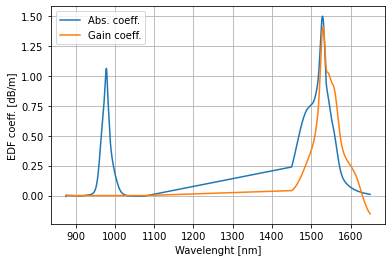

In [6]:
param_edf = parameters()
param_edf.giles = param_giles
edf_fiber = edf(param_edf)
edf_fiber.plot('coeff')

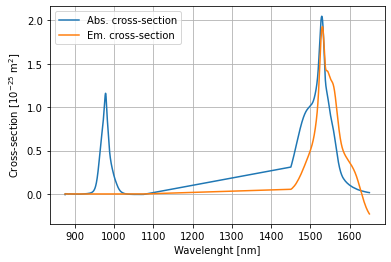

In [7]:
edf_fiber.plot('cross')

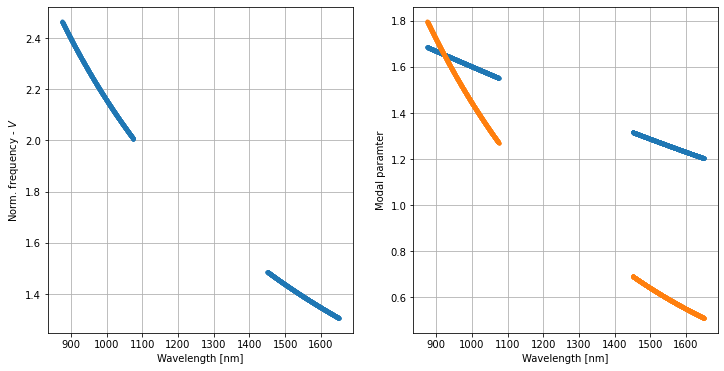

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(1e9*edf_fiber.wavelength, edf_fiber.V, '.')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel(r'Norm. frequency - $V$')
ax[0].grid(True)

ax[1].plot(1e9*edf_fiber.wavelength, edf_fiber.u, '.', label = r'modal $u$')
ax[1].plot(1e9*edf_fiber.wavelength, edf_fiber.v, '.', label = r'modal $v$')
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Modal paramter')
ax[1].grid(True)

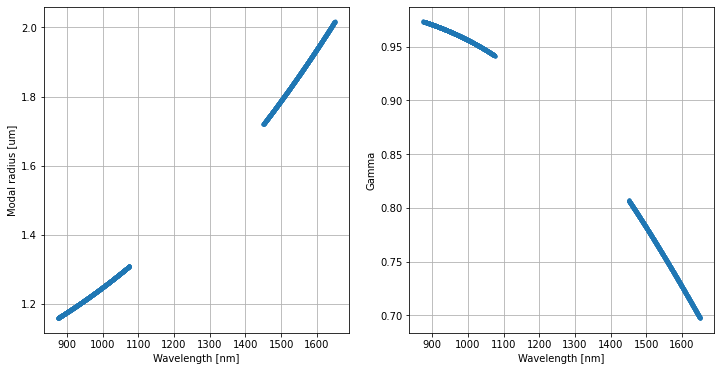

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(1e9*edf_fiber.wavelength, 1e6*edf_fiber.w_gauss, '.')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Modal radius [um]')
ax[0].grid(True)

ax[1].plot(1e9*edf_fiber.wavelength, edf_fiber.gamma, '.')
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Gamma')
ax[1].grid(True)

## Signal class

In [10]:
from numpy.fft import fft, ifft, fftfreq

class signal():
    def __init__(self, signal, Fs:float, Fc:float):
        self.Fs = Fs
        self.Fc = Fc
        _,self.isy = np.shape(signal)
        if (self.isy==1):
            signal = np.concatenate((signal, np.zeros(np.shape(signal))), axis=1)
            self.isy+=1
        self.set_frequency(signal)      
        self.set_spectrum(signal)

    def set_frequency(self, signal):
        self.frequency = self.Fs * fftfreq(len(signal)) + self.Fc
    
    def set_spectrum(self, signal):
        self.spectrum = fft(signal, axis = 0)

    def get_frequency_hz(self):
        return self.frequency
    
    def get_frequency_m(self):
        return c/self.frequency
    
    def get_spectrum_w(self):
        return np.reshape(
            np.abs(self.spectrum / len(self.frequency)) ** 2, 
            (self.isy * len(self.frequency)), order="F"
        ) 
    
    def get_spectrum_dBm(self):
        return 10*np.log10(1e3*self.get_spectrum_w())

    def plot(self):
        plt.plot(1e9*self.get_frequency_m(), 
                 self.get_spectrum_dBm()[:len(self)],
                 label = 'Pol. X',
                 lw = 2,
                 )
        plt.plot(1e9*self.get_frequency_m(), 
                 self.get_spectrum_dBm()[len(self):],
                 label = 'Pol. Y',
                 lw = 2,
                 alpha=0.5,
                 )
        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Power [dBm]')
        plt.legend()
        plt.grid(True)

    def __len__(self) -> int:
        return len(self.frequency)

**Example**

In [11]:
# Transmitter parameters:
paramTx = parameters()
paramTx.NSb = 2**10          # number os symbols
paramTx.SpS = 256            # samples per symbol
paramTx.Rs  = 30e9           # symbol rate
paramTx.lw  = 1e6            # laser linewidth
paramTx.Nch = 2              # number of channels
paramTx.Nmodes   = 1         # number of modes
paramTx.Pch_dBm  = -40       # channel power
paramTx.freqSpac = 2.5e12    # channel bandwith
paramTx.Fc       = c/1540e-9 # central frequency

In [12]:
# CW signal with two optical channels: 1530 and 1550 nm.
t = np.arange(0, paramTx.NSb * paramTx.SpS)
Fs = paramTx.Rs*paramTx.SpS

# central frequencies of the WDM channels
freqGrid = (
    np.arange(-np.floor(paramTx.Nch / 2), np.floor(paramTx.Nch / 2) + 1, 1)
    * paramTx.freqSpac
)
if (paramTx.Nch % 2) == 0:
    freqGrid += paramTx.freqSpac / 2
# linear power
power_lin = 10**((paramTx.Pch_dBm)/10 - 3)
# comb generation
sigTxWDM = np.zeros((len(t), paramTx.Nmodes), dtype="complex")
for indCh in range(paramTx.Nch):
    for indMode in range(paramTx.Nmodes):
        pho_pn_lo = phaseNoise(paramTx.lw, len(t), 1/Fs)
        sigLO   = np.sqrt(power_lin)*np.exp(1j*pho_pn_lo)
        sigTxWDM[:, indMode] += sigLO * np.exp(1j * 2 * np.pi * (freqGrid[indCh] / Fs) * t)

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_1132\1360280182.py:33: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1e3*self.get_spectrum_w())


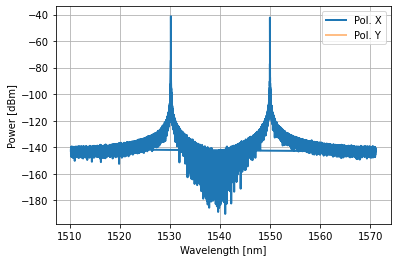

In [13]:
signal_tx = signal(sigTxWDM, Fs, paramTx.Fc)
signal_tx.plot()

## Pump class

In [14]:
class pump():
    def __init__(self, parameter):
        # pump parameters
        self.direction = getattr(parameter, 'direction', 'forward')
        self.pump_power = getattr(parameter, 'power', np.array([100e-3]))
        self.pump_frequency = c/getattr(parameter, 'wavelength', np.array([980e-9]))
        if (len(self.pump_power)!=len(self.pump_frequency)):
            raise TypeError("pump object: invalid length.")
        
    def __len__(self) -> int:
        return len(self.pump_frequency)
    
    def __str__(self) -> str:
        return f'\n## Pump\ntype: {self.direction} \npower {self.pump_power} W\nfrequency {self.pump_frequency} Hz\nwavelength {c/self.pump_frequency} m'

**Example**

In [15]:
forward_pump = parameters()
pumpF = pump(forward_pump)
print(pumpF)


## Pump
type: forward 
power [0.1] W
frequency [3.05910671e+14] Hz
wavelength [9.8e-07] m


In [16]:
forward_pump = parameters()
forward_pump.power = np.array([100e-3, 150e-3])
forward_pump.wavelength = np.array([980e-9, 976e-9])
pumpF = pump(forward_pump)
print(pumpF)


## Pump
type: forward 
power [0.1  0.15] W
frequency [3.05910671e+14 3.07164404e+14] Hz
wavelength [9.80e-07 9.76e-07] m


In [17]:
backward_pump = parameters()
backward_pump.direction = 'backward'
pumpB = pump(backward_pump)
print(pumpB)


## Pump
type: backward 
power [0.1] W
frequency [3.05910671e+14] Hz
wavelength [9.8e-07] m


## Control class

In [18]:
class control():
    def __init__(self, parameter):
        # controller parameters
        self.kp = getattr(parameter, "kp", 1e-2)
        self.ki = getattr(parameter, "ki", 1e-2)
        self.kd = getattr(parameter, "kd", 5e-2)
        # setpoint and control type
        self.mode = getattr(parameter, "mode", "AGC")
        if self.mode in {"AGC", "APC", "none"}:
            self.setpoint = getattr(parameter, "setpoint", 20)  # dB (for gain) and dBm (for power)
        else:
            raise TypeError("control.type invalid argument - [AGC, APC, none].")
        
    def __str__(self)->str:
        return f'\n## Control\nmode: {self.mode}\nset-point: {self.setpoint}\nkp parameter: {self.kp}\nkd parameter: {self.kd}\nki parameter: {self.ki}'

**Example**

In [19]:
control_parameters = parameters()
control_obj = control(control_parameters)
print(control_obj)


## Control
mode: AGC
set-point: 20
kp parameter: 0.01
kd parameter: 0.05
ki parameter: 0.01


## Solver class

In [20]:
class solver():
    def __init__(self, parameter):
        # solver error
        self.tol = getattr(parameter, "tol", 2 / 100)
        self.tolCtrl = getattr(parameter, "tolCtrl", 0.5)     

    def __str__(self)->str:
        return f'\n## Solver\ntol: {self.tol}\ntolCtrl: {self.tolCtrl}'

**Example**

In [21]:
solver_parameters= parameters()
solver_obj = solver(solver_parameters)
print(solver_obj)


## Solver
tol: 0.02
tolCtrl: 0.5


## Noise class

In [25]:
class noise():
    def __init__(self, parameters):
        self.noise_band = parameters.noise_band
        self.optical_band = parameters.optical_band
        self.set_ase_frequency()

    def set_ase_frequency(self):
        return np.arange(-self.optical_band / 2, self.optical_band / 2, self.noise_band) + parameters.Fc

    def __len__(self):
        return len(self.ase_frequency)

## EDFA class

In [26]:
class edfa(signal, edf, pump, control, solver, noise):
    def __init__(self, signal_opt, Fs, Fc, parameters):        
        signal.__init__(self, signal_opt, Fs, Fc)
        edf.__init__(self, parameters.edf)
        
        pump.__init__(self, parameters.pump)
        control.__init__(self, parameters.control)
        solver.__init__(self, parameters.solver)
        
        noise.__init__(self, parameters.noise)
        optical_band = self.frequency.max() - self.frequency.min()
        noise.set_ase_frequency(optical_band, Fc)
        print(noise.__len__(self))

    def __str__(self)->str:
        return pump.__str__(self) + control.__str__(self) + solver.__str__(self)

**Example**

In [27]:
param_edfa = parameters()
param_edfa.edf = param_edf
param_edfa.pump = parameters()
param_edfa.control = parameters()
param_edfa.solver = parameters()
param_edfa.noise = parameters()
edfa_obj = edfa(sigTxWDM, Fs, paramTx.Fc, param_edfa)
print(edfa_obj)

TypeError: set_ase_frequency() takes 1 positional argument but 3 were given

In [ ]:
edfa_obj.frequency

array([1.94670427e+14, 1.94670457e+14, 1.94670486e+14, ...,
       1.94670339e+14, 1.94670369e+14, 1.94670398e+14])